In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/text_pre_processing.csv')
df.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
0,0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,"['Donald', 'Trump', 'just', 'couldn', 't', 'wi...",['pic.twitter.com/4FPAe2KypA'],donald trump just couldn t wish all americans ...,[],"['@realDonaldTrump', '@TalbertSwan', '@calvins...",donald trump sends out embarrassing new year’s...,"['donald', 'trump', 'just', 'couldn', 'wish', ...","['donald', 'trump', 'sends', 'out', 'embarrass..."
1,1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,"['House', 'Intelligence', 'Committee', 'Chairm...",[],house intelligence committee chairman devin nu...,[],[],drunk bragging trump staffer started russian c...,"['house', 'intelligence', 'committee', 'chairm...","['drunk', 'bragging', 'trump', 'staffer', 'sta..."
2,2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"['On', 'Friday', 'it', 'was', 'revealed', 'tha...","['pic.twitter.com/XtZW5PdU2b', 'pic.twitter.co...","on friday, it was revealed that former milwauk...",[],"['@SheriffClarke', '@SheriffClarke', '@KeithLe...",sheriff david clarke becomes an internet joke ...,"['on', 'it', 'was', 'revealed', 'that', 'forme...","['sheriff', 'david', 'clarke', 'becomes', 'an'..."
3,3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"['On', 'Christmas', 'day', 'Donald', 'Trump', ...","['https://t.co/Fg7VacxRtJ', 'pic.twitter.com/5...","on christmas day, donald trump announced that ...",[],"['@pbump', '@_cingraham', '@_cingraham', '@_ci...",trump is so obsessed he even has obama’s name ...,"['on', 'christmas', 'day', 'donald', 'trump', ...","['trump', 'is', 'so', 'obsessed', 'he', 'even'..."
4,4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,"['Pope', 'Francis', 'used', 'his', 'annual', '...",[],pope francis used his annual christmas day mes...,[],[],pope francis just called out donald trump duri...,"['pope', 'francis', 'used', 'his', 'annual', '...","['pope', 'francis', 'just', 'called', 'out', '..."


In [5]:
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head(5)

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,"['Donald', 'Trump', 'just', 'couldn', 't', 'wi...",['pic.twitter.com/4FPAe2KypA'],donald trump just couldn t wish all americans ...,[],"['@realDonaldTrump', '@TalbertSwan', '@calvins...",donald trump sends out embarrassing new year’s...,"['donald', 'trump', 'just', 'couldn', 'wish', ...","['donald', 'trump', 'sends', 'out', 'embarrass..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,"['House', 'Intelligence', 'Committee', 'Chairm...",[],house intelligence committee chairman devin nu...,[],[],drunk bragging trump staffer started russian c...,"['house', 'intelligence', 'committee', 'chairm...","['drunk', 'bragging', 'trump', 'staffer', 'sta..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"['On', 'Friday', 'it', 'was', 'revealed', 'tha...","['pic.twitter.com/XtZW5PdU2b', 'pic.twitter.co...","on friday, it was revealed that former milwauk...",[],"['@SheriffClarke', '@SheriffClarke', '@KeithLe...",sheriff david clarke becomes an internet joke ...,"['on', 'it', 'was', 'revealed', 'that', 'forme...","['sheriff', 'david', 'clarke', 'becomes', 'an'..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"['On', 'Christmas', 'day', 'Donald', 'Trump', ...","['https://t.co/Fg7VacxRtJ', 'pic.twitter.com/5...","on christmas day, donald trump announced that ...",[],"['@pbump', '@_cingraham', '@_cingraham', '@_ci...",trump is so obsessed he even has obama’s name ...,"['on', 'christmas', 'day', 'donald', 'trump', ...","['trump', 'is', 'so', 'obsessed', 'he', 'even'..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,"['Pope', 'Francis', 'used', 'his', 'annual', '...",[],pope francis used his annual christmas day mes...,[],[],pope francis just called out donald trump duri...,"['pope', 'francis', 'used', 'his', 'annual', '...","['pope', 'francis', 'just', 'called', 'out', '..."


In [20]:
df = df.drop(['text_tokens'], axis = 1)
df = df.drop(['text_urls'], axis = 1)
df = df.drop(['title_urls'], axis = 1)
df = df.drop(['twitter_handles'], axis = 1)
df = df.drop(['clean_text_tokens'], axis = 1)
df = df.drop(['clean_title_tokens'], axis = 1)
df.head(5)

,title,text,subject,date,label,caps_in_title,clean_text,clean_title
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,11,donald trump just couldn t wish all americans ...,donald trump sends out embarrassing new year’s...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,8,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,15,"on friday, it was revealed that former milwauk...",sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,19,"on christmas day, donald trump announced that ...",trump is so obsessed he even has obama’s name ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,11,pope francis used his annual christmas day mes...,pope francis just called out donald trump duri...


In [12]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [16]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

The following steps include train/test split of 70/30, remove stop-words and tokenize text using NLTK tokenizer. For our first try we tag every complaint title with its label.It probably must be done also with its text or title + text !

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['title']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['title']), tags=[r.label]), axis=1)

An example

In [30]:
train_tagged.values[1]

TaggedDocument(words=['danish', 'minister', 'republishes', 'controversial', 'prophet', 'cartoon', 'on', 'facebook'], tags=[True])

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

In general, when you like to build some model using words, simply labeling/one-hot encoding them is a plausible way to go. However, when using such encoding, the words lose their meaning. e.g, if we encode Paris as id_4, France as id_6 and power as id_8, France will have the same relation to power as with Paris. We would prefer a representation in which France and Paris will be closer than France and power.
The word2vec, presented in 2013 , intends to give you just that: a numeric representation for each word, that will be able to capture such relations as above. this is part of a wider concept in machine learning — the feature vectors.

Such representations, encapsulate different relations between words, like synonyms, antonyms, or analogies, such as this one:

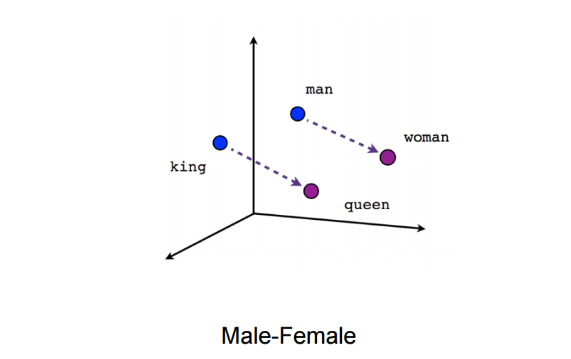

 King to queen is like man to woman.

The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found.

There are 2 methods for doc2vec : 


1.   **Distributed Bag of Words (DBOW)** : The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.
2.   **Distributed Memory (DM)** : DM acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document





Now we create a doc2vec model using distributed bag of words (DBOW), with 300-dimensional feature vectors.As for workers we use the system core threads to train the model.

In [28]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 27046/27046 [00:00<00:00, 1452337.10it/s]


Now we must train the model for 30 epochs ( =  cycle through the full training dataset)

In [31]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 27046/27046 [00:00<00:00, 2257091.19it/s]


CPU times: user 1min 18s, sys: 15.1 s, total: 1min 33s
Wall time: 1min


Now we build the final vector for the classification

In [37]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

Train the logistic regression classifier

In [38]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6347481021394065
Testing F1 score: 0.5929286570654835


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We will then try using the DM method for doc2vec and so we create a DM doc2vec model with a vector size with 300 words and iterating over the training corpus 30 times.


In [39]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 27046/27046 [00:00<00:00, 1442328.62it/s]


In [40]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 27046/27046 [00:00<00:00, 1824220.41it/s]


CPU times: user 2min 43s, sys: 50.1 s, total: 3min 33s
Wall time: 2min 29s


In [41]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5073326432022084
Testing F1 score: 0.5138751260439479


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The accurancy and the F1 score are less using DM than DBOW. To improve the scores we will create a new model that it will be a combination of those 2.

In [44]:
!pip install testfixtures

     |████████████████████████████████| 95 kB 2.1 MB/s 


In [45]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

Build vectors for the classifier

In [46]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

Finally train the model

In [47]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5454623878536922
Testing F1 score: 0.5433541306439104


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Although the scores are better than the DM method, they are not as good as the DBOW.